In [1]:
import torch
import numpy as np
from models import mar
from models.vae import AutoencoderKL
from torchvision.utils import save_image
from util import download
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

/export/share/zhenhailong/miniconda3/envs/sfr-xlearner/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# model_type = "mar_huge" #@param ["mar_base", "mar_large", "mar_huge"]
model_type = "mar_base" #@param ["mar_base", "mar_large", "mar_huge"]
num_sampling_steps_diffloss = 100 #@param {type:"slider", min:1, max:1000, step:1}
if model_type == "mar_base":
  download.download_pretrained_marb(overwrite=False)
  diffloss_d = 6
  diffloss_w = 1024
elif model_type == "mar_large":
  download.download_pretrained_marl(overwrite=False)
  diffloss_d = 8
  diffloss_w = 1280
elif model_type == "mar_huge":
  download.download_pretrained_marh(overwrite=False)
  diffloss_d = 12
  diffloss_w = 1536
else:
  raise NotImplementedError
model = mar.__dict__[model_type](
  buffer_size=64,
  diffloss_d=diffloss_d,
  diffloss_w=diffloss_w,
  num_sampling_steps=str(num_sampling_steps_diffloss)
).to(device)
state_dict = torch.load("pretrained_models/mar/{}/checkpoint-last.pth".format(model_type))["model_ema"]
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL(embed_dim=16, ch_mult=(1, 1, 2, 2, 4), ckpt_path="pretrained_models/vae/kl16.ckpt").cuda().eval()
     

Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
Loading pre-trained KL-VAE
Missing keys:
[]
Unexpected keys:
[]
Restored from pretrained_models/vae/kl16.ckpt


  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:29<00:00,  2.19it/s]


torch.Size([1, 16, 16, 16])


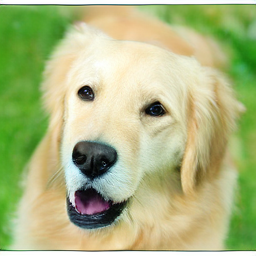

In [10]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
np.random.seed(seed)
num_ar_steps = 64 #@param {type:"slider", min:1, max:256, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
cfg_schedule = "constant" #@param ["linear", "constant"]
temperature = 1.0 #@param {type:"slider", min:0.9, max:1.1, step:0.01}

class_labels = 207, 360, 388, 113, 355, 980, 323, 979 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# class_labels = [207] #@param {type:"raw"}
# samples_per_row = 1 #@param {type:"number"}

with torch.cuda.amp.autocast():
  sampled_tokens = model.sample_tokens(
      bsz=len(class_labels), num_iter=num_ar_steps,
      cfg=cfg_scale, cfg_schedule=cfg_schedule,
      labels=torch.Tensor(class_labels).long().cuda(),
      temperature=temperature, progress=True)
  print(sampled_tokens.shape)
  sampled_images = vae.decode(sampled_tokens / 0.2325)

# Save and display images:
save_image(sampled_images, "sample.png", nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [7]:
vae
# reconstruct with vae:
reconstructed = vae(sampled_images)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         